# House Prices Prediction

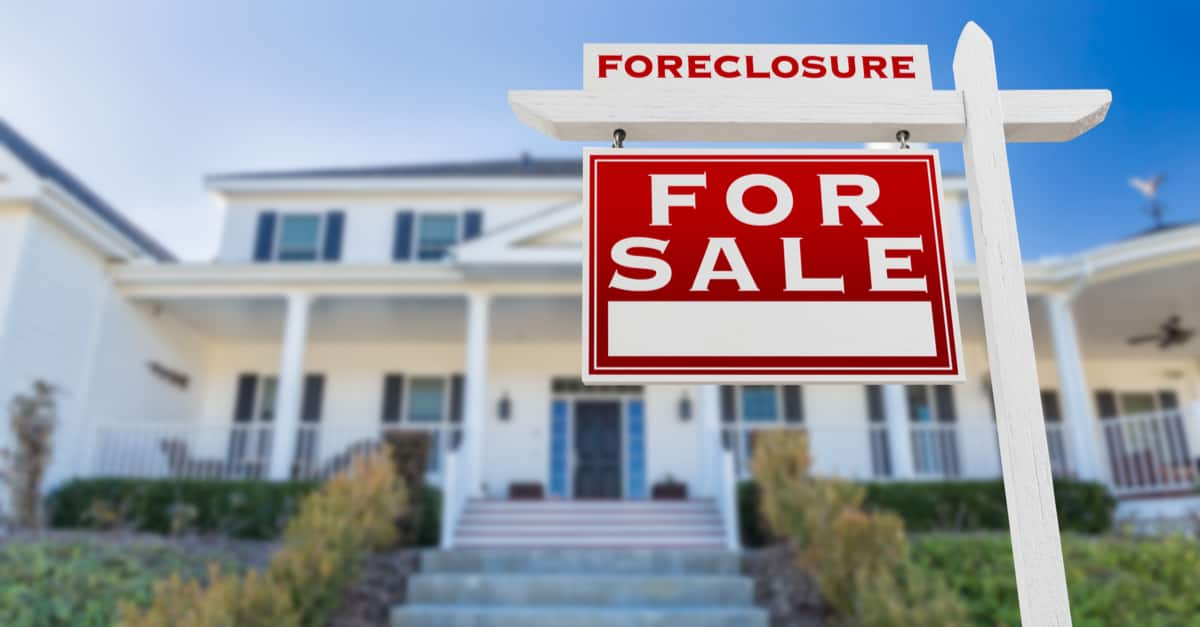

In this kernel, we will use the __Ames Housing__ dataset to predict the sales price for each house. This dataset is provided in Kaggle used in [their competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).

Below is the outline of this kernel:

1. Importing Required Libraries
2. Understanding Evaluation Matric
3. Reading Data
4. EDA
   - Overview
   - Missing Values
   - Duplicated Values
   - Target Variable Distribution
   - Independent Variables
        - Categorical Features
        - Numerical Features
        - Date Features
   - Correlation
6. Preprocessing
7. Modeling
8. Summary

# Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
import warnings
import random
import scipy.stats as stats

# model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

# Understanding Evaluation Metric

In this Kaggle competition, models are evaluated on Root-Mean-Squared-Error (RMSE).

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
$$

# Reading Data

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# EDA
## Overview

In [3]:
train_eda = train.copy()
test_eda = test.copy()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Notes on the data above:
- Many columns have missing values.
- Some object data types can be converted to categorical to save memory.
- ``SalePrice`` is our target variable.

I will convert the date features to object data types for now.

In [5]:
date_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

for col in date_cols:
    train_eda[col] = train_eda[col].astype(object)
    test_eda[col] = test_eda[col].astype(object)

In [6]:
train_eda.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
TotRmsAbvGrd        6.0       7.00      14.0  
Fireplaces          1.0       1.00       3.0  
GarageCars          2.0       2.00       4.0  
GarageArea        480.0     576.00    1418.0  
WoodDeckSF          0.0     168.00     857.0  
OpenPorchSF        25.0      68.00     547.0  
EnclosedPorch       0.0       0.00     552.0  
3SsnPorch           0.0       0.00     508.0  
ScreenPorch         0.0       0.00     480.0  
PoolArea            0.0       0.00     738

In [7]:
train_eda.describe(include='O').T

count unique      top  freq
MSZoning         1460      5       RL  1151
Street           1460      2     Pave  1454
Alley              91      2     Grvl    50
LotShape         1460      4      Reg   925
LandContour      1460      4      Lvl  1311
Utilities        1460      2   AllPub  1459
LotConfig        1460      5   Inside  1052
LandSlope        1460      3      Gtl  1382
Neighborhood     1460     25    NAmes   225
Condition1       1460      9     Norm  1260
Condition2       1460      8     Norm  1445
BldgType         1460      5     1Fam  1220
HouseStyle       1460      8   1Story   726
YearBuilt        1460    112     2006    67
YearRemodAdd     1460     61     1950   178
RoofStyle        1460      6    Gable  1141
RoofMatl         1460      8  CompShg  1434
Exterior1st      1460     15  VinylSd   515
Exterior2nd      1460     16  VinylSd   504
MasVnrType        588      3  BrkFace   445
ExterQual        1460      4       TA   906
ExterCond        1460      5       TA  1282
Foundation       1460      6    PConc   647
BsmtQual         1423      4       TA   649
BsmtCond         1423      4       TA  1311
BsmtExposure     1422      4       No   953
BsmtFinType1     1423      6      Unf   430
BsmtFinType2     1422      6      Unf  1256
Heating          1460      6     GasA  1428
HeatingQC        1460      5       Ex   741
CentralAir       1460      2        Y  1365
Electrical       1459      5    SBrkr  1334
KitchenQual      1460      4       TA   735
Functional       1460      7      Typ  1360
FireplaceQu       770      5       Gd   380
GarageType       1379      6   Attchd   870
GarageYrBlt    1379.0   97.0   2005.0  65.0
GarageFinish     1379      3      Unf   605
GarageQual       1379      5       TA  1311
GarageCond       1379      5       TA  1326
PavedDrive       1460      3        Y  1340
PoolQC              7      3       Gd     3
Fence             281      4    MnPrv   157
MiscFeature        54      4     Shed    49
MoSold           1460     12        6   253
YrSold           1460      5     2009   338
SaleType         1460      9       WD  1267
SaleCondition    1460      6   Normal  1198

## Missing Values

In [8]:
train_n_missing_values = train_eda.isna().sum()
train_prop_missing_values = train_eda.isna().sum() / len(train_eda)
test_n_missing_values = test_eda.isna().sum()
test_prop_missing_values = test_eda.isna().sum() / len(test_eda)

df_missing_values = pd.DataFrame({'train_n_missing_values': train_n_missing_values, 
                                  'train_prop_missing_values': train_prop_missing_values,
                                  'test_n_missing_values': test_n_missing_values, 
                                  'test_prop_missing_values': test_prop_missing_values}).sort_values('train_prop_missing_values', ascending=False).round(5)

mask = (df_missing_values['train_n_missing_values'] != 0) | (df_missing_values['test_n_missing_values'] != 0)

df_missing_values[mask]

train_n_missing_values  train_prop_missing_values  \
PoolQC                          1453                    0.99521   
MiscFeature                     1406                    0.96301   
Alley                           1369                    0.93767   
Fence                           1179                    0.80753   
MasVnrType                       872                    0.59726   
FireplaceQu                      690                    0.47260   
LotFrontage                      259                    0.17740   
GarageFinish                      81                    0.05548   
GarageQual                        81                    0.05548   
GarageType                        81                    0.05548   
GarageYrBlt                       81                    0.05548   
GarageCond                        81                    0.05548   
BsmtExposure                      38                    0.02603   
BsmtFinType2                      38                    0.02603   
BsmtQual                          37                    0.02534   
BsmtCond                          37                    0.02534   
BsmtFinType1                      37                    0.02534   
MasVnrArea                         8                    0.00548   
Electrical                         1                    0.00068   
MSZoning                           0                    0.00000   
Utilities                          0                    0.00000   
TotalBsmtSF                        0                    0.00000   
SaleType                           0                    0.00000   
SalePrice                          0                    0.00000   
Exterior1st                        0                    0.00000   
BsmtFinSF1                         0                    0.00000   
BsmtFinSF2                         0                    0.00000   
BsmtFullBath                       0                    0.00000   
BsmtHalfBath                       0                    0.00000   
BsmtUnfSF                          0                    0.00000   
Exterior2nd                        0                    0.00000   
Functional                         0                    0.00000   
GarageArea                         0                    0.00000   
GarageCars                         0                    0.00000   
KitchenQual                        0                    0.00000   

              test_n_missing_values  test_prop_missing_values  
PoolQC                       1456.0                   0.99794  
MiscFeature                  1408.0                   0.96504  
Alley                        1352.0                   0.92666  
Fence                        1169.0                   0.80123  
MasVnrType                    894.0                   0.61275  
FireplaceQu                   730.0                   0.50034  
LotFrontage                   227.0                   0.15559  
GarageFinish                   78.0                   0.05346  
GarageQual                     78.0                   0.05346  
GarageType                     76.0                   0.05209  
GarageYrBlt                    78.0                   0.05346  
GarageCond                     78.0                   0.05346  
BsmtExposure                   44.0                   0.03016  
BsmtFinType2                   42.0                   0.02879  
BsmtQual                       44.0                   0.03016  
BsmtCond                       45.0                   0.03084  
BsmtFinType1                   42.0                   0.02879  
MasVnrArea                     15.0                   0.01028  
Electrical                      0.0                   0.00000  
MSZoning                        4.0                   0.00274  
Utilities                       2.0                   0.00137  
TotalBsmtSF                     1.0                   0.00069  
SaleType                        1.0                   0.00069  
SalePrice                       NaN                       NaN  
E

According to the data description, it seems that missing values in some features should be categorized as a distinct group. For example, 99.5% of ``PoolQC`` values are missing, but this indicates that these properties do not have a pool, so they should be labeled as "No Pool" instead left as null.

### Imputing Missing Values

In [9]:
garage_object_cols = train_eda.loc[:, train_eda.columns.str.contains('Garage')].select_dtypes(object).columns
garage_num_cols = train_eda.loc[:, train_eda.columns.str.contains('Garage')].select_dtypes(np.number).columns
bsmt_object_cols = train_eda.loc[:, train_eda.columns.str.contains('Bsmt')].select_dtypes(object).columns
bsmt_num_cols = train_eda.loc[:, train_eda.columns.str.contains('Bsmt')].select_dtypes(np.number).columns
masvnr_cols = train_eda.columns[train_eda.columns.str.contains('MasVnr')].tolist()
impute_none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [10]:
def impute_with_none(df):
    new_df = df.copy()
    # Garage
    new_df.loc[df['GarageQual'].isnull(), garage_object_cols] = new_df.loc[df['GarageFinish'].isnull(), garage_object_cols].fillna('None')
    new_df.loc[df['GarageQual'] == 'None', garage_num_cols] = new_df.loc[df['GarageFinish'] == 'None', garage_num_cols].fillna(0)
    # Bsmt
    new_df.loc[df['BsmtQual'].isnull(), bsmt_object_cols] = new_df.loc[df['BsmtQual'].isnull(), bsmt_object_cols].fillna('None')
    new_df.loc[df['BsmtQual'] == 'None', bsmt_num_cols] = new_df.loc[df['BsmtQual'] == 'None', bsmt_num_cols].fillna(0)
    # MasVnr
    new_df['MasVnrArea'] = new_df['MasVnrArea'].fillna(0)
    new_df.loc[(df['MasVnrArea'] == 0) & (new_df['MasVnrType'].isna()) , masvnr_cols] = new_df.loc[(df['MasVnrArea'] ==0) & (new_df['MasVnrType'].isna()) , masvnr_cols].fillna('None')
    # Fireplace
    new_df['FireplaceQu'] = new_df['FireplaceQu'].fillna('None')
    # others
    new_df.loc[new_df[impute_none_cols].isna().any(axis=1), impute_none_cols] = new_df.loc[new_df[impute_none_cols].isna().any(axis=1), impute_none_cols].fillna('None')
    
    return new_df

train_eda = impute_with_none(train_eda)
test_eda = impute_with_none(test_eda)

In [11]:
def impute_with_mean_LF(df, base_df):
    new_df = df.copy()
    lotfrontage_means = base_df.groupby('LotConfig')['LotFrontage'].mean()
    
    new_df['LotFrontage'] = new_df.apply(
        lambda row: lotfrontage_means[row['LotConfig']] if pd.isnull(row['LotFrontage']) else row['LotFrontage'],axis=1
    )

    return new_df

train_eda = impute_with_mean_LF(train_eda,train_eda)
test_eda = impute_with_mean_LF(test_eda, train_eda)

In [12]:
train_impute_mode_cols = train_eda.columns[train_eda.isna().any(axis=0)]
test_impute_mode_cols = test_eda.columns[test_eda.isna().any(axis=0)]

def impute_with_mode(df, base_df, cols):
    new_df = df.copy()
    for col in cols:
        most_frequent = base_df[col].mode()[0]
        new_df[col] = new_df[col].fillna(most_frequent)
        
    return new_df

train_eda = impute_with_mode(train_eda, train_eda, train_impute_mode_cols)
test_eda = impute_with_mode(test_eda, train_eda, test_impute_mode_cols)

Let's check if we have successfully imputed missing values for both the training and test sets.

In [13]:
train_n_missing_values = train_eda.isna().sum()
train_prop_missing_values = train_eda.isna().sum() / len(train_eda)
test_n_missing_values = test_eda.isna().sum()
test_prop_missing_values = test_eda.isna().sum() / len(test_eda)

df_missing_values = pd.DataFrame({'train_n_missing_values': train_n_missing_values, 
                                  'train_prop_missing_values': train_prop_missing_values,
                                  'test_n_missing_values': test_n_missing_values, 
                                  'test_prop_missing_values': test_prop_missing_values}).sort_values('train_prop_missing_values', ascending=False).round(5)

mask = (df_missing_values['train_n_missing_values'] != 0) | (df_missing_values['test_n_missing_values'] != 0)

df_missing_values[mask]

train_n_missing_values  train_prop_missing_values  \
SalePrice                       0                        0.0   

           test_n_missing_values  test_prop_missing_values  
SalePrice                    NaN                       NaN

## Duplicated Values

In [14]:
train_eda[train_eda.duplicated()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 81 columns]

## Target Variable Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


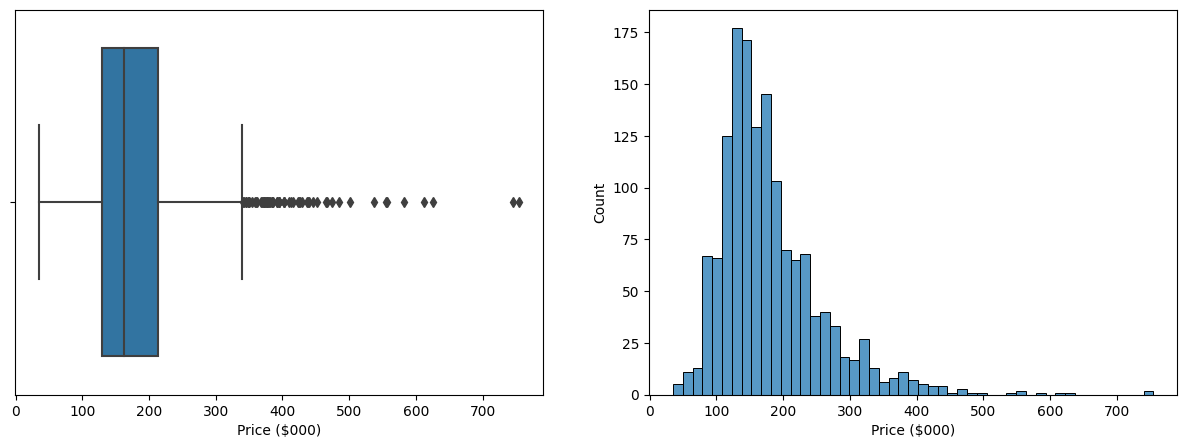

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(data = train_eda,
            x = train_eda['SalePrice'] / 1000,
            ax = axes[0])

axes[0].set_xlabel('Price ($000)')

sns.histplot(data = train_eda,
             x = train_eda['SalePrice'] / 1000,
             ax = axes[1])

axes[1].set_xlabel("Price ($000)");

Notes on the charts above:
- It is clear that ``SalesPrice`` is skewed right: they extend much farther to the right of the median than to the left. 
- By applying ``np.log`` to the target variable, we can transform it to have a more bell-shaped distribution, which often leads tobetter model performance. Note that we will need to apply ``np.exp`` to the output to interpret the results. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


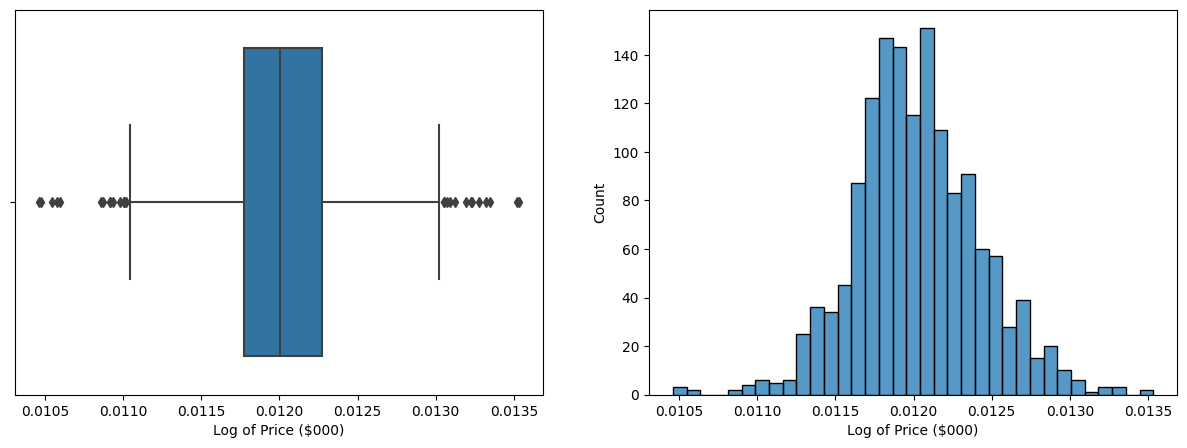

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(data = train_eda,
            x = np.log(train_eda['SalePrice']) / 1000,
            ax = axes[0])

axes[0].set_xlabel('Log of Price ($000)')

sns.histplot(data = train_eda,
             x = np.log(train_eda['SalePrice']) / 1000,
             ax = axes[1])

axes[1].set_xlabel("Log of Price ($000)");

## Independent Features

In [17]:
# one-hot encoding
cat_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','Neighborhood',
                'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                'Heating','CentralAir','Electrical','Functional','GarageType','Fence','MiscFeature','SaleType','SaleCondition']

# ordinal encoding
ordinal_features = ['LandSlope','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                    'HeatingQC','KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive', 'PoolQC']

# no change required
ordinal_features_v2 = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars']

# maybe standardization
continuous_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                       'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

dates_features = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']

In [18]:
MSSubClass_mapping = {20: '1-STORY 1946',
                      30: '1-STORY 1945',
                      40: '1-STORY FIN',
                      45: '1-1/2 STORY UNF',
                      50: '1-1/2 STORY FIN',
                      60: '2-STORY 1946',
                      70: '2-STORY 1945',
                      75: '2-1/2 STORY',
                      80: 'SPLIT/MULTILEV',
                      85: 'SPLIT FOYER',
                      90: 'DUPLEX',
                      120: '1-STORY PUD',
                      150: '1-1/2 STORY PUD',
                      160: '2-STORY PUD',
                      180: 'PUD - MULTILEV',
                      190: '2 FAM CONV'
                     }

train_eda['MSSubClass'] = train_eda['MSSubClass'].map(MSSubClass_mapping)
test_eda['MSSubClass'] = test_eda['MSSubClass'].map(MSSubClass_mapping)

### Categorical Features

In [19]:
train_eda[cat_features] = train_eda[cat_features].astype('category')

In [20]:
warnings.filterwarnings("ignore", category=FutureWarning)

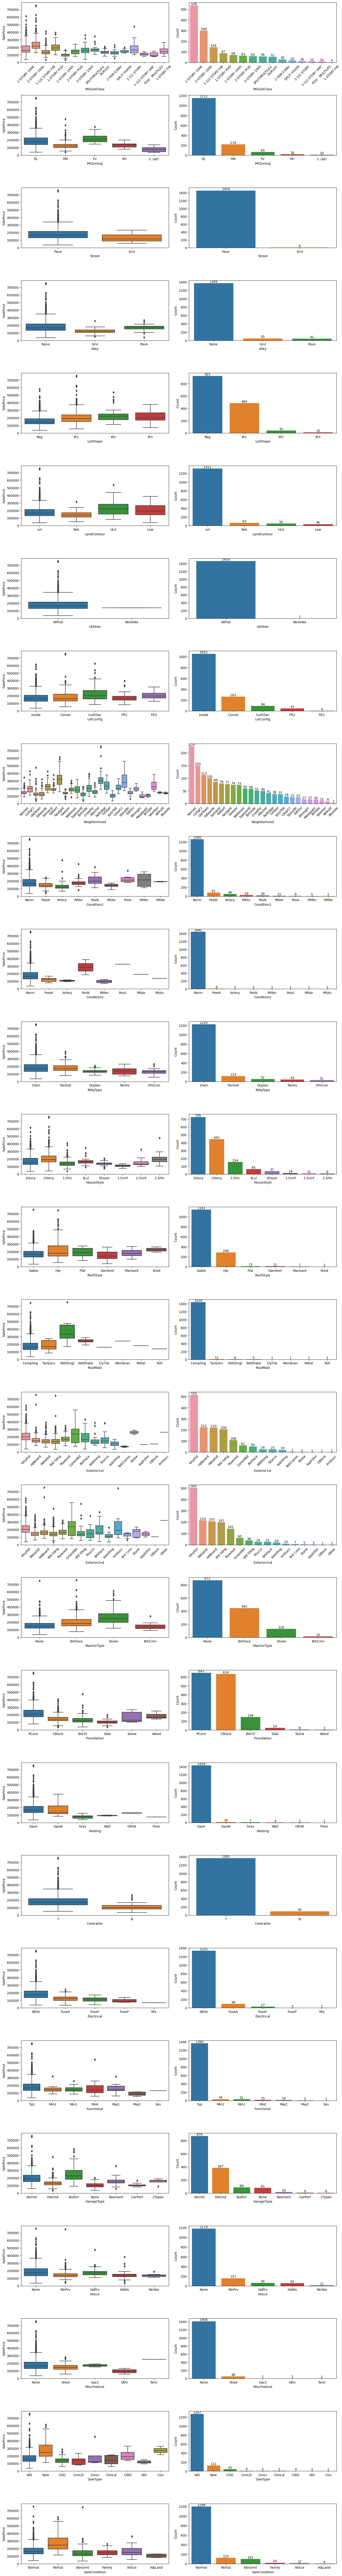

In [21]:
num_rows = len(cat_features)

fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 4 * num_rows))

if num_rows == 1:
    axs = [axs]

for i, col in enumerate(cat_features):
    category_order = train_eda[col].value_counts(dropna = False).index.tolist()

    # Boxplot on the left (first column), sorted by value counts
    sns.boxplot(data=train_eda, x=col, y='SalePrice', ax=axs[i][0], order=category_order)
    axs[i][0].set_ylabel('SalePrice')
    if col in ["MSSubClass", "Neighborhood", "Exterior1st", "Exterior2nd"]:
        axs[i][0].tick_params(axis='x', labelrotation=45)
    else:
        axs[i][0].tick_params(axis='x', labelrotation=0)
    axs[i][0].set_xlabel(col)

    # Bar plot on the right (second column)
    value_counts = train_eda[col].value_counts(dropna = False)
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axs[i][1], order=category_order)
    axs[i][1].set_ylabel('Count')
    if col in ["MSSubClass", "Neighborhood", "Exterior1st", "Exterior2nd"]:
        axs[i][1].tick_params(axis='x', labelrotation=45)
    else:
        axs[i][1].tick_params(axis='x', labelrotation=0)
    axs[i][1].set_xlabel(col)

    # Adding data labels
    for j, value in enumerate(value_counts.values):
        axs[i][1].text(j, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

There are some categories that appear only a few times. They are most likely noise, so let's simplify them a bit.

In [22]:
def simplify(train_df, test_df, threshold=10):
    new_train_df = train_df.copy()
    new_test_df = test_df.copy()

    # train
    for feature in cat_features:
        counts = new_train_df[feature].value_counts()
        categories_to_group = counts[counts < threshold].index
        new_train_df[feature] = new_train_df[feature].apply(lambda x: 'Other' if x in categories_to_group else x)
        new_train_df[feature] = new_train_df[feature].astype('category')
    # test
    for feature in cat_features:
        new_test_df[feature] = np.where(new_test_df[feature].isin(new_train_df[feature].unique().tolist()), new_test_df[feature], 'Other')
        new_test_df[feature] = new_test_df[feature].astype('category')
        
    return new_train_df, new_test_df

train_eda, test_eda = simplify(train_eda, test_eda)

### Numerical Features
#### Ordinal

In [23]:
ord_enc = OrdinalEncoder()

train_ord_transformed = ord_enc.fit_transform(train_eda[ordinal_features])
test_ord_transformed = ord_enc.transform(test_eda[ordinal_features])

train_eda.loc[:, ordinal_features] = train_ord_transformed
train_eda[ordinal_features] = train_eda[ordinal_features].astype(np.int16)

test_eda.loc[:, ordinal_features] = test_ord_transformed
test_eda[ordinal_features] = test_eda[ordinal_features].astype(np.int16)

In [24]:
train_eda[ordinal_features_v2] = train_eda[ordinal_features_v2].astype(np.int16)
test_eda[ordinal_features_v2] = test_eda[ordinal_features_v2].astype(np.int16)

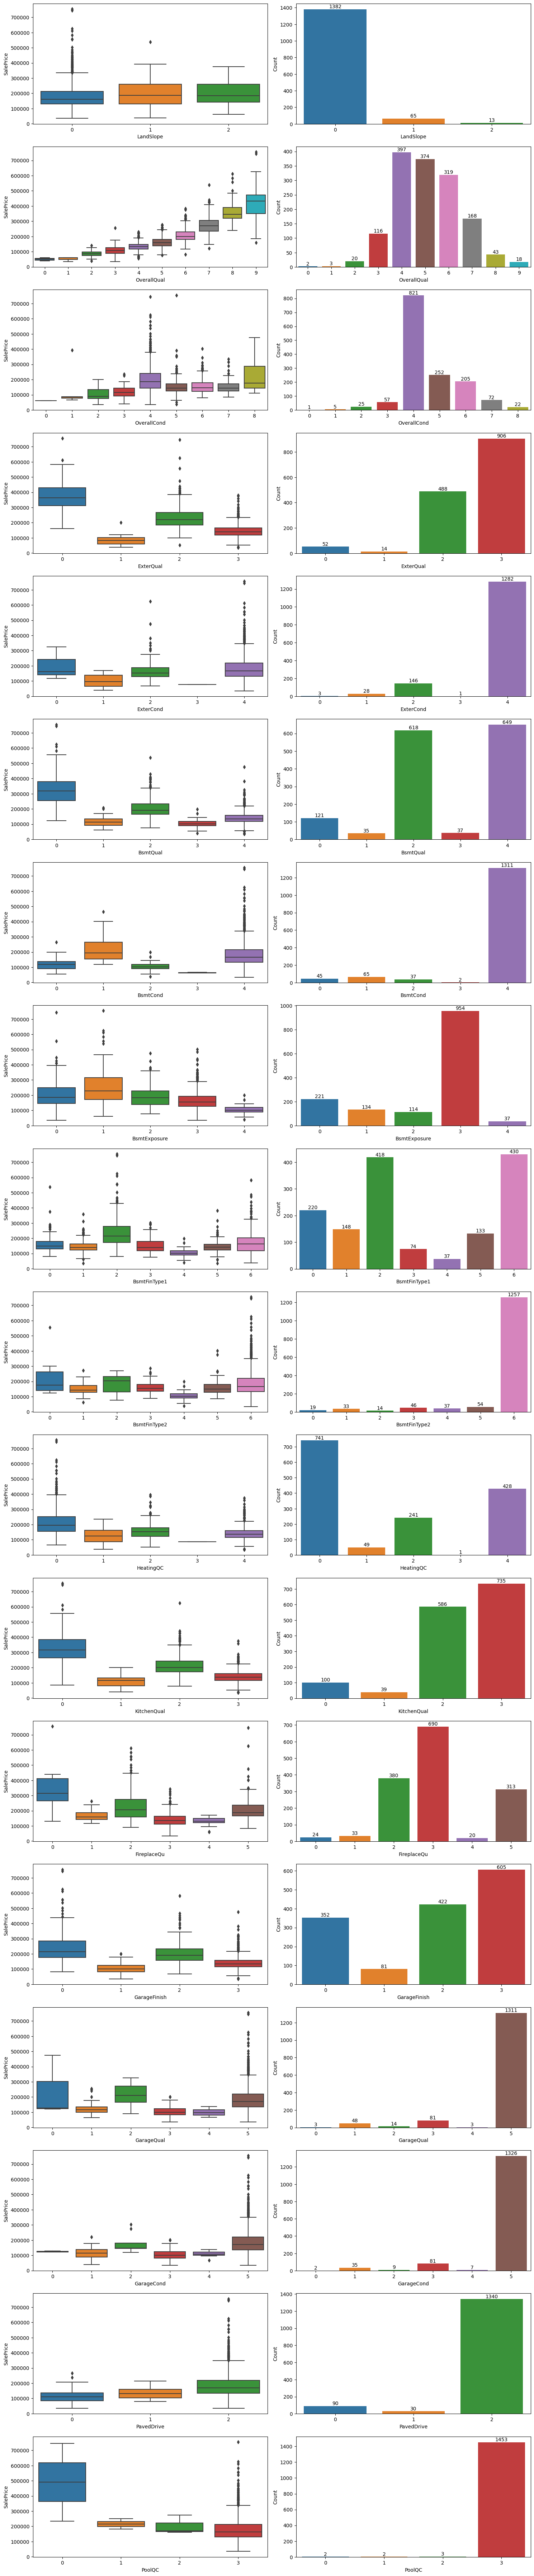

In [25]:
num_rows = len(ordinal_features)

fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 4 * num_rows))

if num_rows == 1:
    axs = [axs]

for i, col in enumerate(ordinal_features):
    category_order = train_eda[col].value_counts(dropna = False).sort_index().index.tolist()

    # Boxplot on the left (first column), sorted by value counts
    sns.boxplot(data=train_eda, x=col, y='SalePrice', ax=axs[i][0], order=category_order)
    axs[i][0].set_ylabel('SalePrice')
    axs[i][0].set_xlabel(col)

    # Bar plot on the right (second column)
    value_counts = train_eda[col].value_counts(dropna = False).sort_index()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axs[i][1])
    axs[i][1].set_ylabel('Count')
    axs[i][1].set_xlabel(col)

    # Adding data labels
    for j, value in enumerate(value_counts.values):
        axs[i][1].text(j, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

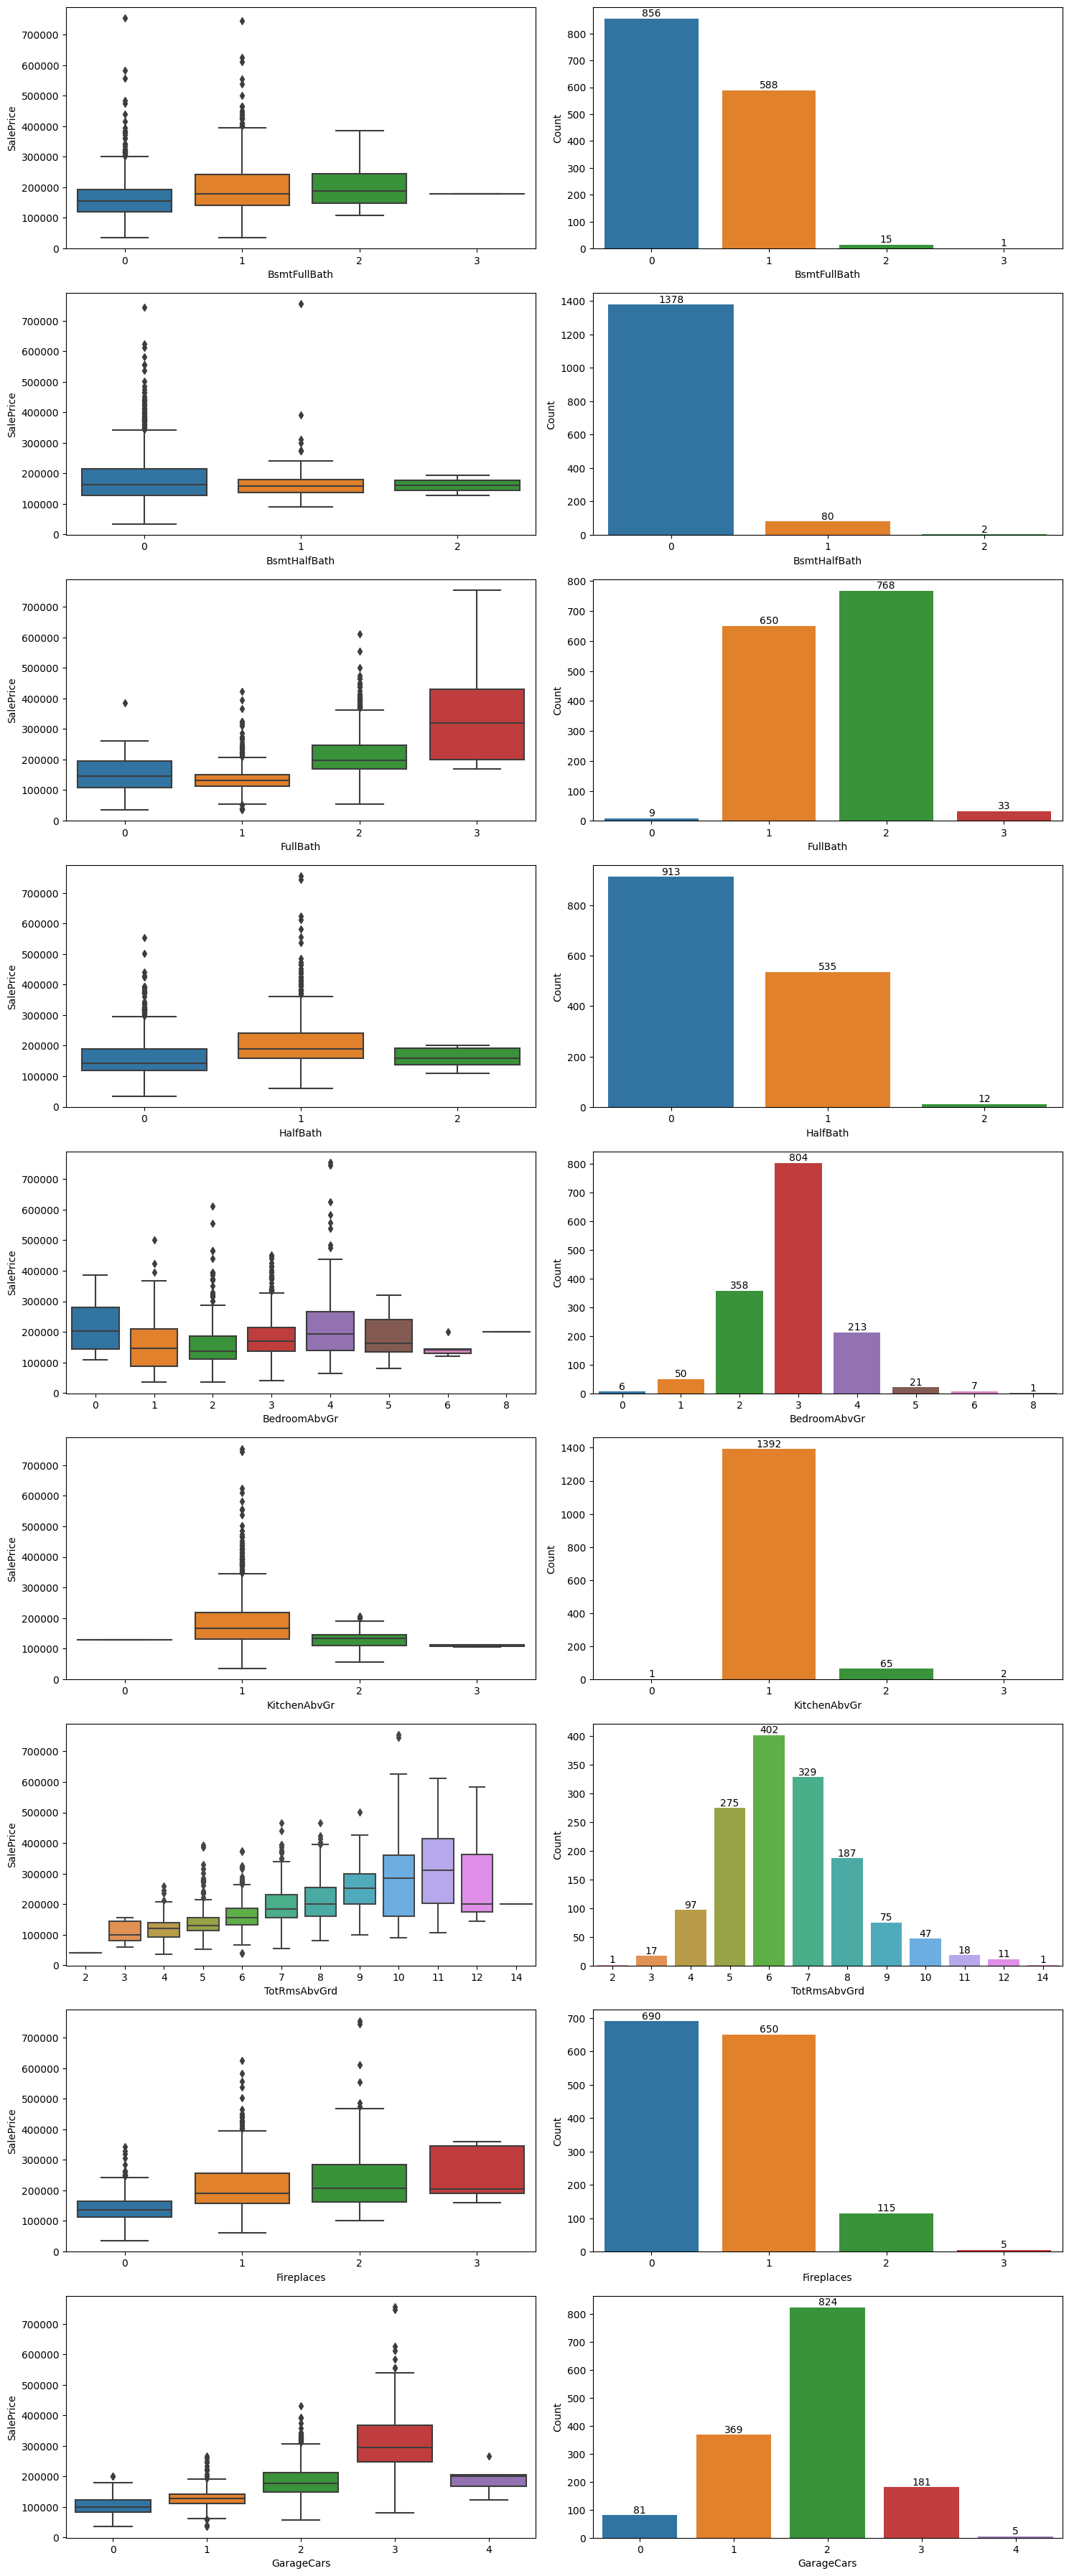

In [26]:
num_rows = len(ordinal_features_v2)

fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 4 * num_rows))

if num_rows == 1:
    axs = [axs]

for i, col in enumerate(ordinal_features_v2):
    category_order = train_eda[col].value_counts(dropna = False).sort_index().index.tolist()

    # Boxplot on the left (first column), sorted by value counts
    sns.boxplot(data=train_eda, x=col, y='SalePrice', ax=axs[i][0], order=category_order)
    axs[i][0].set_ylabel('SalePrice')
    axs[i][0].set_xlabel(col)

    # Bar plot on the right (second column)
    value_counts = train_eda[col].value_counts(dropna = False).sort_index()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axs[i][1])
    axs[i][1].set_ylabel('Count')
    axs[i][1].set_xlabel(col)

    # Adding data labels
    for j, value in enumerate(value_counts.values):
        axs[i][1].text(j, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Using some discrete features, let's calculate ``bedrooms_ratio`` and ``total_bathrooms``.

In [27]:
def add_new_discrete_features(df):
    new_df = df.copy()
    new_df['bedrooms_ratio'] = new_df['BedroomAbvGr'] / new_df['TotRmsAbvGrd']
    new_df['total_bathrooms'] = new_df['BsmtFullBath'] + (new_df['BsmtHalfBath'] * 0.5) + new_df['FullBath'] + (new_df['HalfBath'] * 0.5)
    
    new_df[['bedrooms_ratio','total_bathrooms']] = new_df[['bedrooms_ratio','total_bathrooms']].astype(np.float16)
    
    return new_df

train_eda = add_new_discrete_features(train_eda)
test_eda = add_new_discrete_features(test_eda)

#### Continuous

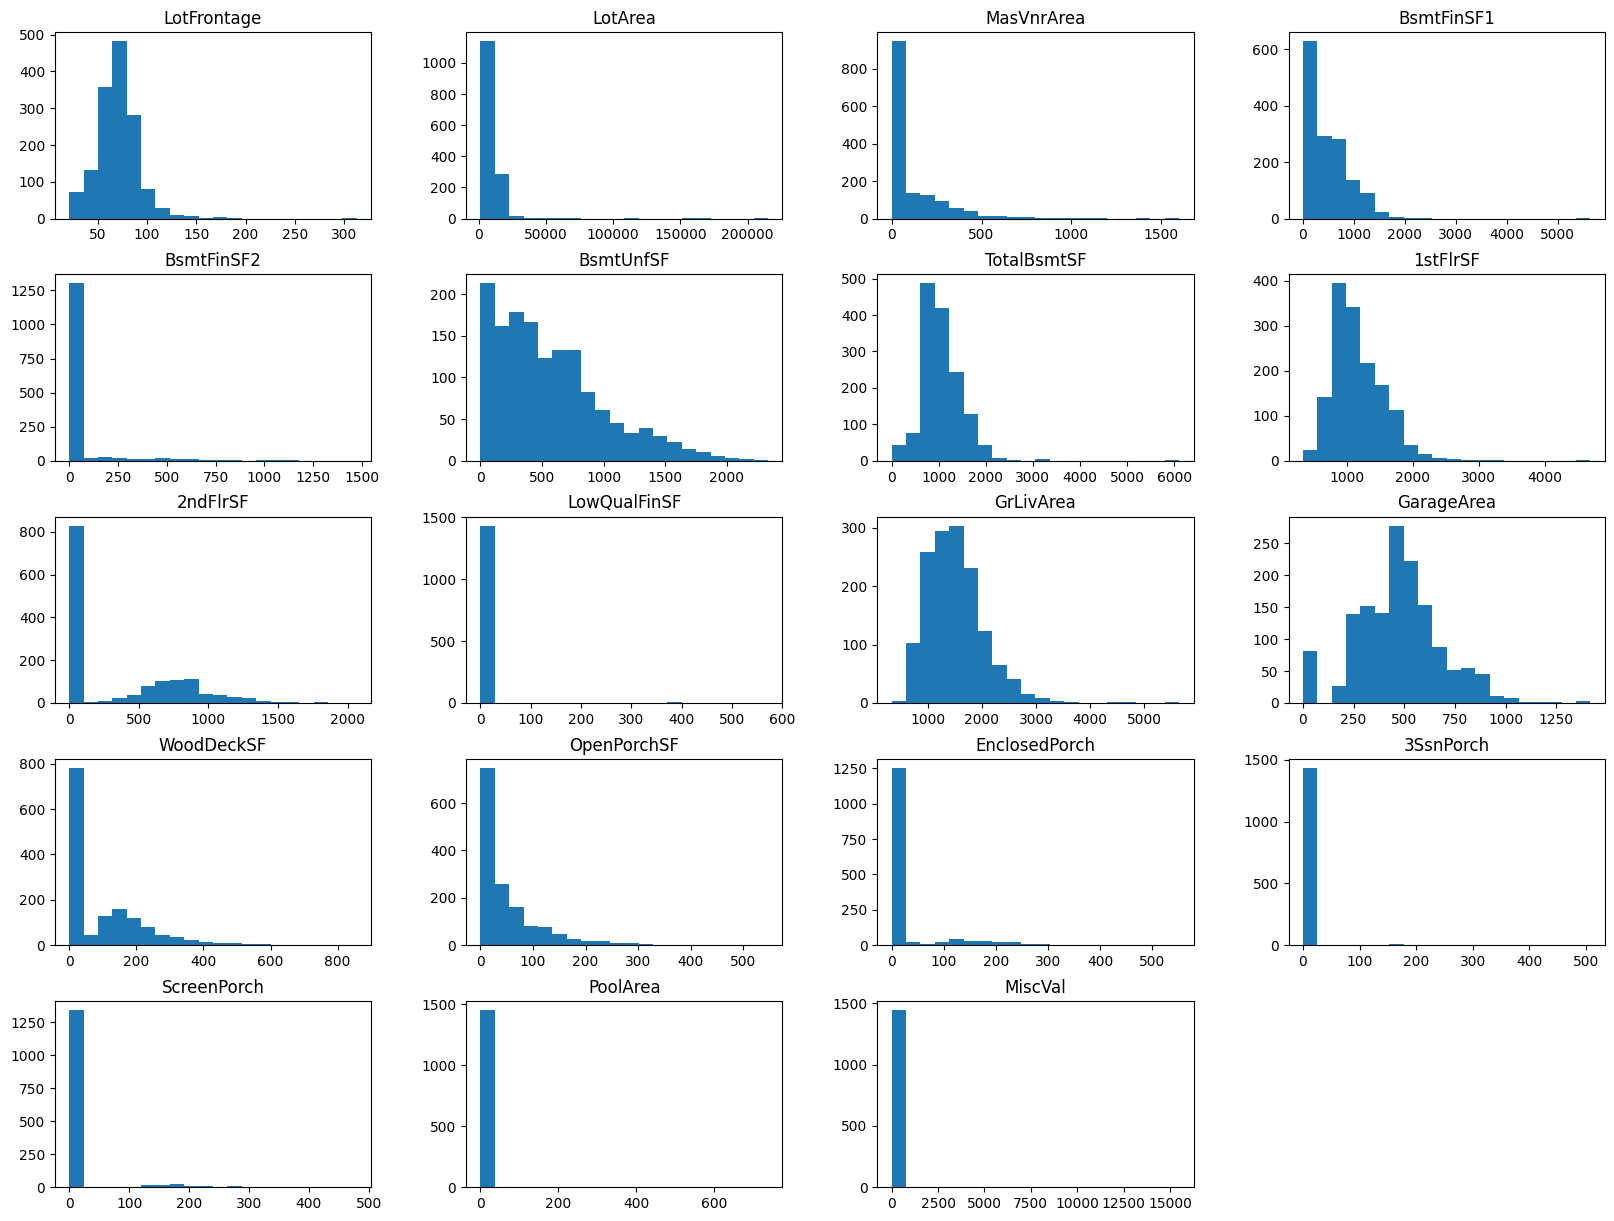

In [28]:
train_eda[continuous_features].hist(bins = 20, figsize = (20, 15), grid = False);

Notes from the charts above:
- Most features are skewed right. Applying some transformation (``np.log``, ``np.sqrt``) will likely help.
- There are multiple square footage-related features, but it seems there is no feature that shows a total square footage for each house.

Let's add a ``TotalSF`` feature.

In [29]:
def add_new_continous_features(df):
    new_df = df.copy()
    new_df['TotalSF'] = new_df['TotalBsmtSF'] + new_df['1stFlrSF'] + new_df['2ndFlrSF']
    
    return new_df

train_eda = add_new_continous_features(train_eda)
test_eda = add_new_continous_features(test_eda)

In [30]:
continuous_features.append('TotalSF')

Using ``np.corrcoef``, we can calculate the correlation coefficient between the quantiles of the data and the quantiles of a normal distribution.

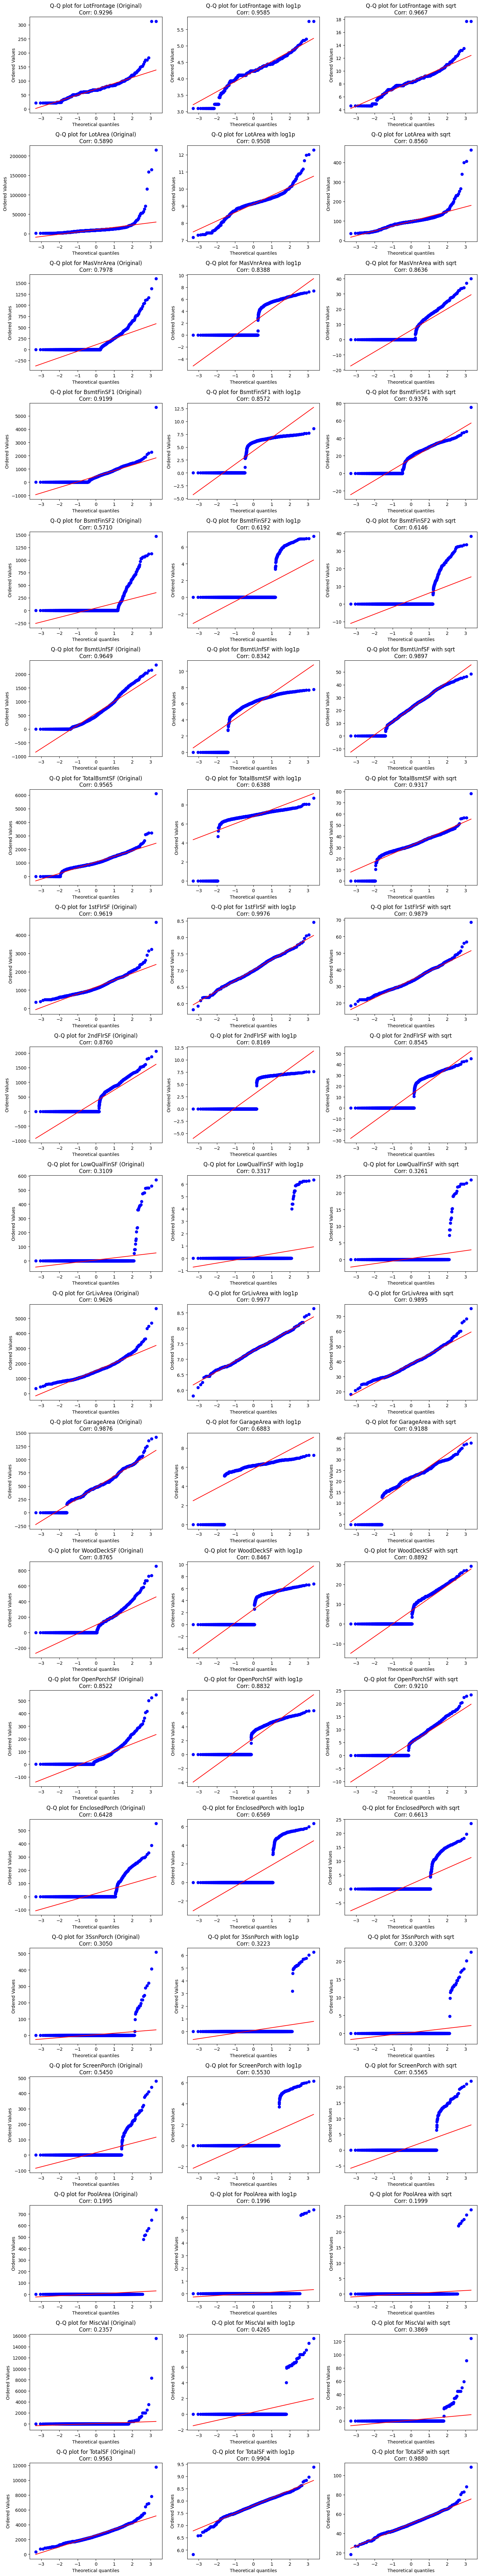

In [31]:
random.seed(42)

fig, axes = plt.subplots(len(continuous_features), 3, figsize=(15, len(continuous_features) * 4))

for i, feature in enumerate(continuous_features):
    # Original data and Q-Q plot
    qq_data = stats.probplot(train_eda[feature], dist="norm", plot=axes[i, 0])
    quantiles = qq_data[0][0]  # Quantiles from the original data
    norm_quantiles = qq_data[0][1]  # Quantiles from the normal distribution
    correlation_original = np.corrcoef(quantiles, norm_quantiles)[0, 1]
    axes[i, 0].set_title(f'Q-Q plot for {feature} (Original)\nCorr: {correlation_original:.4f}')

    # Log1p transformation and Q-Q plot
    log_data = np.log1p(train_eda[feature])
    qq_log = stats.probplot(log_data, dist="norm", plot=axes[i, 1])
    log_quantiles = qq_log[0][0]  # Quantiles from the log1p transformed data
    norm_log_quantiles = qq_log[0][1]  # Quantiles from the normal distribution
    correlation_log = np.corrcoef(log_quantiles, norm_log_quantiles)[0, 1]
    axes[i, 1].set_title(f'Q-Q plot for {feature} with log1p\nCorr: {correlation_log:.4f}')

    # Sqrt transformation and Q-Q plot
    sqrt_data = np.sqrt(train_eda[feature])
    qq_sqrt = stats.probplot(sqrt_data, dist="norm", plot=axes[i, 2])
    sqrt_quantiles = qq_sqrt[0][0]  # Quantiles from the sqrt transformed data
    norm_sqrt_quantiles = qq_sqrt[0][1]  # Quantiles from the normal distribution
    correlation_sqrt = np.corrcoef(sqrt_quantiles, norm_sqrt_quantiles)[0, 1]
    axes[i, 2].set_title(f'Q-Q plot for {feature} with sqrt\nCorr: {correlation_sqrt:.4f}')

plt.tight_layout()
plt.show()

I will apply (or not apply) a transformation for each continuous feature based on this correlation score.

In [32]:
log1p_features = ['LotArea','BsmtFinSF2','1stFlrSF','LowQualFinSF','GrLivArea','3SsnPorch','MiscVal','TotalSF']
sqrt_features = ['LotFrontage','MasVnrArea','BsmtFinSF1','BsmtUnfSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']

def transform_and_drop(df, log_cols, sqrt_cols):
    new_df = df.copy()
    # Apply log1p transformation and create new columns
    for feature in log_cols:
        new_df[f'{feature}_log'] = np.log1p(new_df[feature])
    
    # Apply sqrt transformation and create new columns
    for feature in sqrt_cols:
        new_df[f'{feature}_sqrt'] = np.sqrt(new_df[feature])
    
    # Drop the original columns
    cols_to_drop = log_cols + sqrt_cols
    new_df = new_df.drop(cols_to_drop, axis=1)
    
    return new_df

train_eda = transform_and_drop(train_eda,log1p_features, sqrt_features)
test_eda = transform_and_drop(test_eda,log1p_features, sqrt_features)

In [33]:
original = ['TotalBsmtSF', '2ndFlrSF', 'GarageArea']
new_continuous_features = original + train_eda.columns[train_eda.columns.str.contains('log')].tolist() + train_eda.columns[train_eda.columns.str.contains('sqrt')].tolist()

In [34]:
train_eda[new_continuous_features] = train_eda[new_continuous_features].astype(np.float16)
test_eda[new_continuous_features] = test_eda[new_continuous_features].astype(np.float16)

In [35]:
train_eda['SalePrice_log'] = np.log(train_eda['SalePrice'])

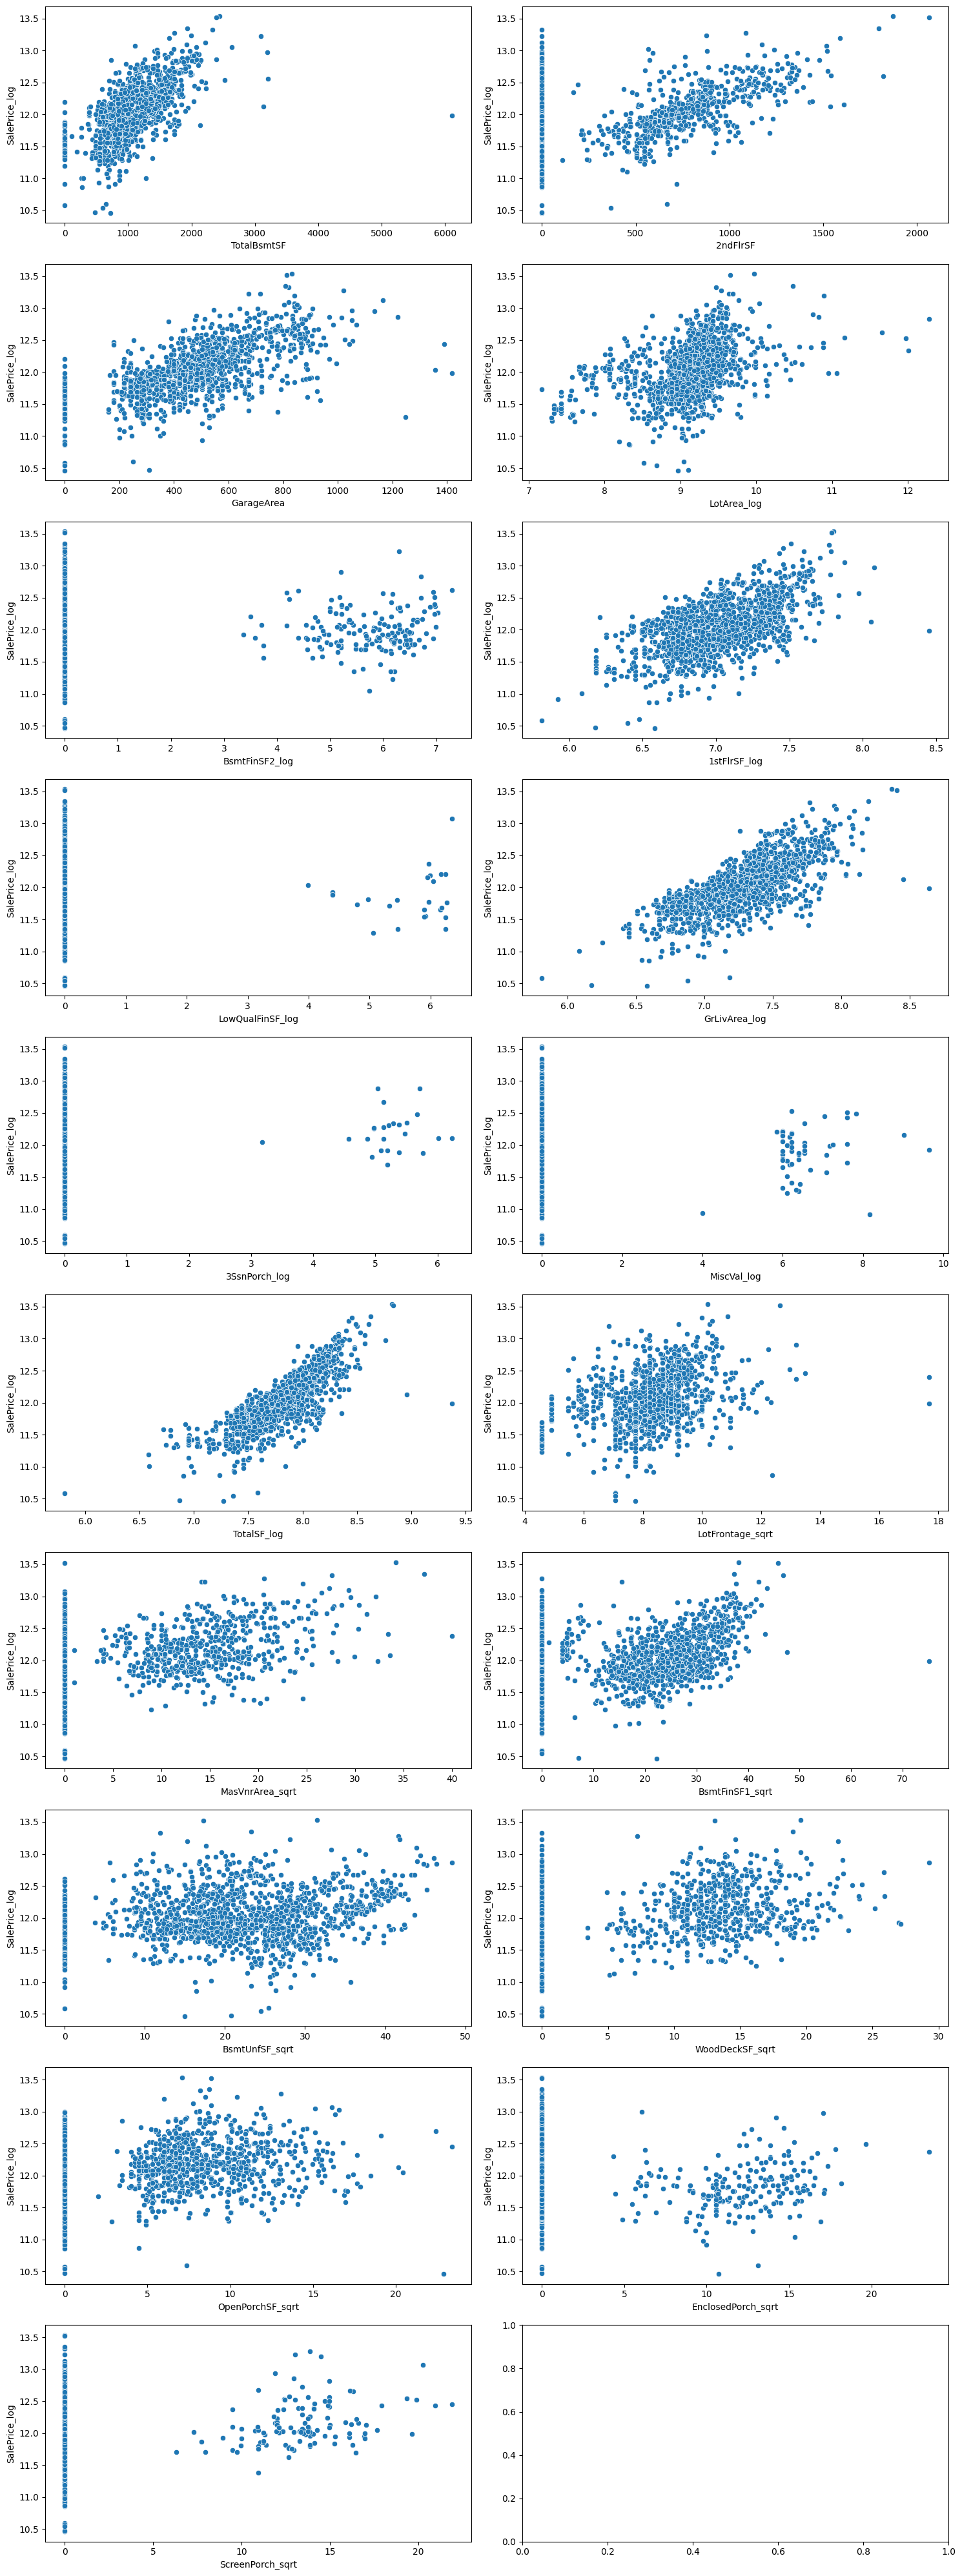

In [36]:
plots_per_row = 2

num_rows = (len(new_continuous_features) + plots_per_row - 1) // plots_per_row

fig, axs = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(15, 4*num_rows))

if num_rows == 1:
    axs = [axs]

for i, col in enumerate(new_continuous_features):
    row_index = i // plots_per_row
    col_index = i % plots_per_row
    sns.scatterplot(data=train_eda, x=col, y='SalePrice_log', ax=axs[row_index][col_index])
    axs[row_index][col_index].set_xlabel(col)
    axs[row_index][col_index].set_ylabel('SalePrice_log')

plt.tight_layout()
plt.show()

We have not yet taken a close look at outliers. Let's use ``cooks_distance`` to identify any __influential outliers__.

In [37]:
X = train_eda[new_continuous_features]
y = train_eda['SalePrice_log']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Calculate influence
influence = model.get_influence()

cooks_d, p_values = influence.cooks_distance

significant_influential_points = p_values < 0.05

In [38]:
train_eda[significant_influential_points == 1]

Id    MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
1298  1299  2-STORY 1946       RL   Pave  None      IR3         Bnk    AllPub   

     LotConfig  LandSlope  ... TotalSF_log LotFrontage_sqrt MasVnrArea_sqrt  \
1298    Corner          0  ...       9.375          17.6875        28.21875   

     BsmtFinSF1_sqrt BsmtUnfSF_sqrt  WoodDeckSF_sqrt  OpenPorchSF_sqrt  \
1298          75.125       21.59375           14.625          17.09375   

     EnclosedPorch_sqrt ScreenPorch_sqrt SalePrice_log  
1298                0.0              0.0     11.982929  

[1 rows x 85 columns]

It seems that there is one influential outlier in the dataset. Let's remove this data point.

In [39]:
train_eda_no_outliers = train_eda[significant_influential_points == 0]

### Date Features

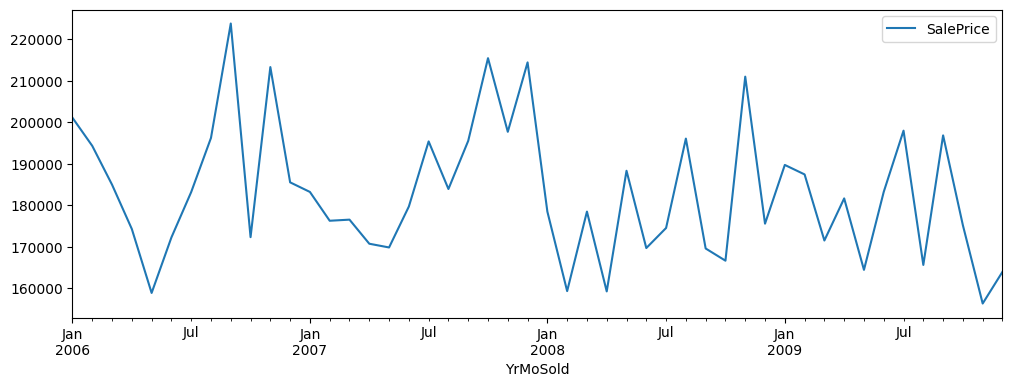

In [40]:
# ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

tsa_df = train_eda.copy()

tsa_df['YrMoSold'] = pd.to_datetime(train_eda['YrSold'].astype(str) + '-' + train_eda['MoSold'].astype(str) + '-01')

tsa_yrmo_df = tsa_df.copy()
tsa_yrmo_df = tsa_yrmo_df.set_index('YrMoSold')

tsa_yrmo_df = tsa_yrmo_df.resample(rule='MS')[['SalePrice']].mean()

tsa_yrmo_df[:'2009-12-01'].plot(figsize = (12,4));

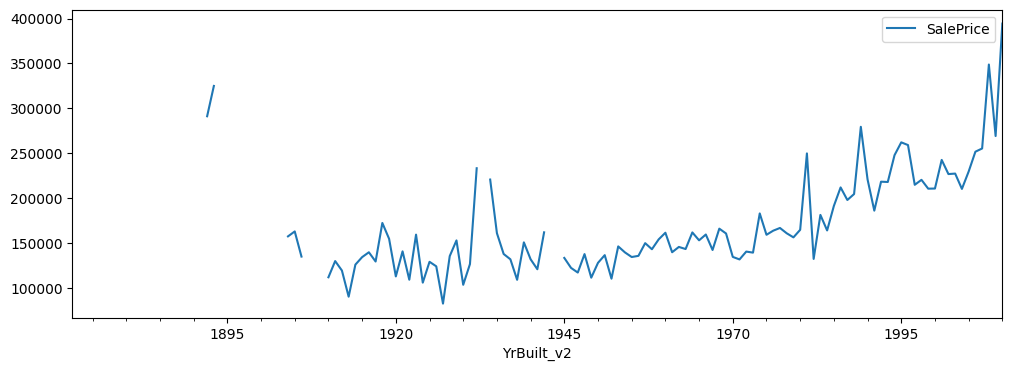

In [41]:
tsa_df['YrBuilt_v2'] = pd.to_datetime(tsa_df['YearBuilt'].astype(str) + '-' + '12-31')

tsa_yr_df = tsa_df.copy()
tsa_yr_df = tsa_yr_df.set_index('YrBuilt_v2')

tsa_yr_df = tsa_yr_df.resample(rule='Y')[['SalePrice']].mean()

tsa_yr_df.plot(figsize = (12,4));

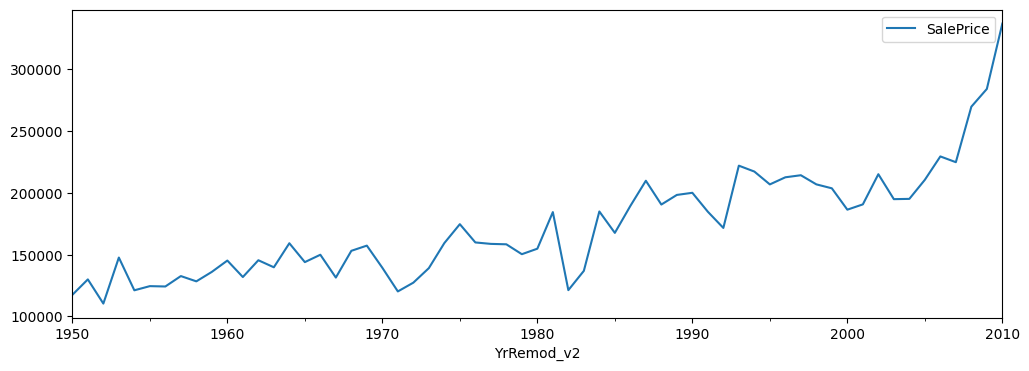

In [42]:
tsa_df['YrRemod_v2'] = pd.to_datetime(tsa_df['YearRemodAdd'].astype(str) + '-' + '12-31')

tsa_yr_df = tsa_df.copy()
tsa_yr_df = tsa_yr_df.set_index('YrRemod_v2')

tsa_yr_df = tsa_yr_df.resample(rule='Y')[['SalePrice']].mean()

tsa_yr_df.plot(figsize = (12,4));

Looking at the plots, we can observe that ``YearBuilt`` and ``YearRemodAdd`` have a multiplicative trend while both do not show clear seasonality. Let's calculate the age of the houses, as it should be a good proxy of these trends. It might be better to model the time series forecast separately and use the outputs from this time series model as input for a second model that predicts house prices. However, I prefer to keep the model simple in this kernel, so we will not pursue that approach this time. 

In [43]:
def add_age_features(df):
    new_df = df.copy()
    
    new_df['Age'] = new_df['YrSold'] - new_df['YearBuilt']
    new_df['Age_incl_Remod'] = new_df['YrSold'] - new_df['YearRemodAdd']
    
    new_df['GarageYrBlt'] = np.where(new_df['GarageYrBlt'] == 'None', -1, new_df['GarageYrBlt'])
    new_df['Age_Garage'] = np.where(new_df['GarageYrBlt'] == -1, -1, new_df['YrSold'] - new_df['GarageYrBlt'])
    
    new_df[['Age', 'Age_incl_Remod', 'Age_Garage']] = new_df[['Age', 'Age_incl_Remod', 'Age_Garage']].astype(int)
  
    new_df['YrMoSold'] = pd.to_datetime(new_df['YrSold'].astype(str) + '-' + new_df['MoSold'].astype(str) + '-01').dt.strftime('%Y-%m').astype('category')
    new_df[['Age','Age_incl_Remod','Age_Garage']] = new_df[['Age','Age_incl_Remod','Age_Garage']].astype(np.int16)
    
    bins = [ -1, 0, 1, 4, 7, 10, 14, 20, 29, 33, 39, 44, 50, 57, 70, np.inf]
    labels =['Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','Group10','Group11','Group12','Group13','Group14','Group15']
    
    new_df['Age_Garage_Group'] = pd.cut(new_df['Age_Garage'], bins=bins, labels=labels)
    new_df['Age_Garage_Group'] = new_df['Age_Garage_Group'].astype('category')
    
    new_df = new_df.drop(['YrSold','MoSold','YearBuilt','YearRemodAdd','GarageYrBlt','Age_Garage'], axis=1)
    
    return new_df

train_eda_no_outliers = add_age_features(train_eda_no_outliers)
test_eda = add_age_features(test_eda)

## Correlation

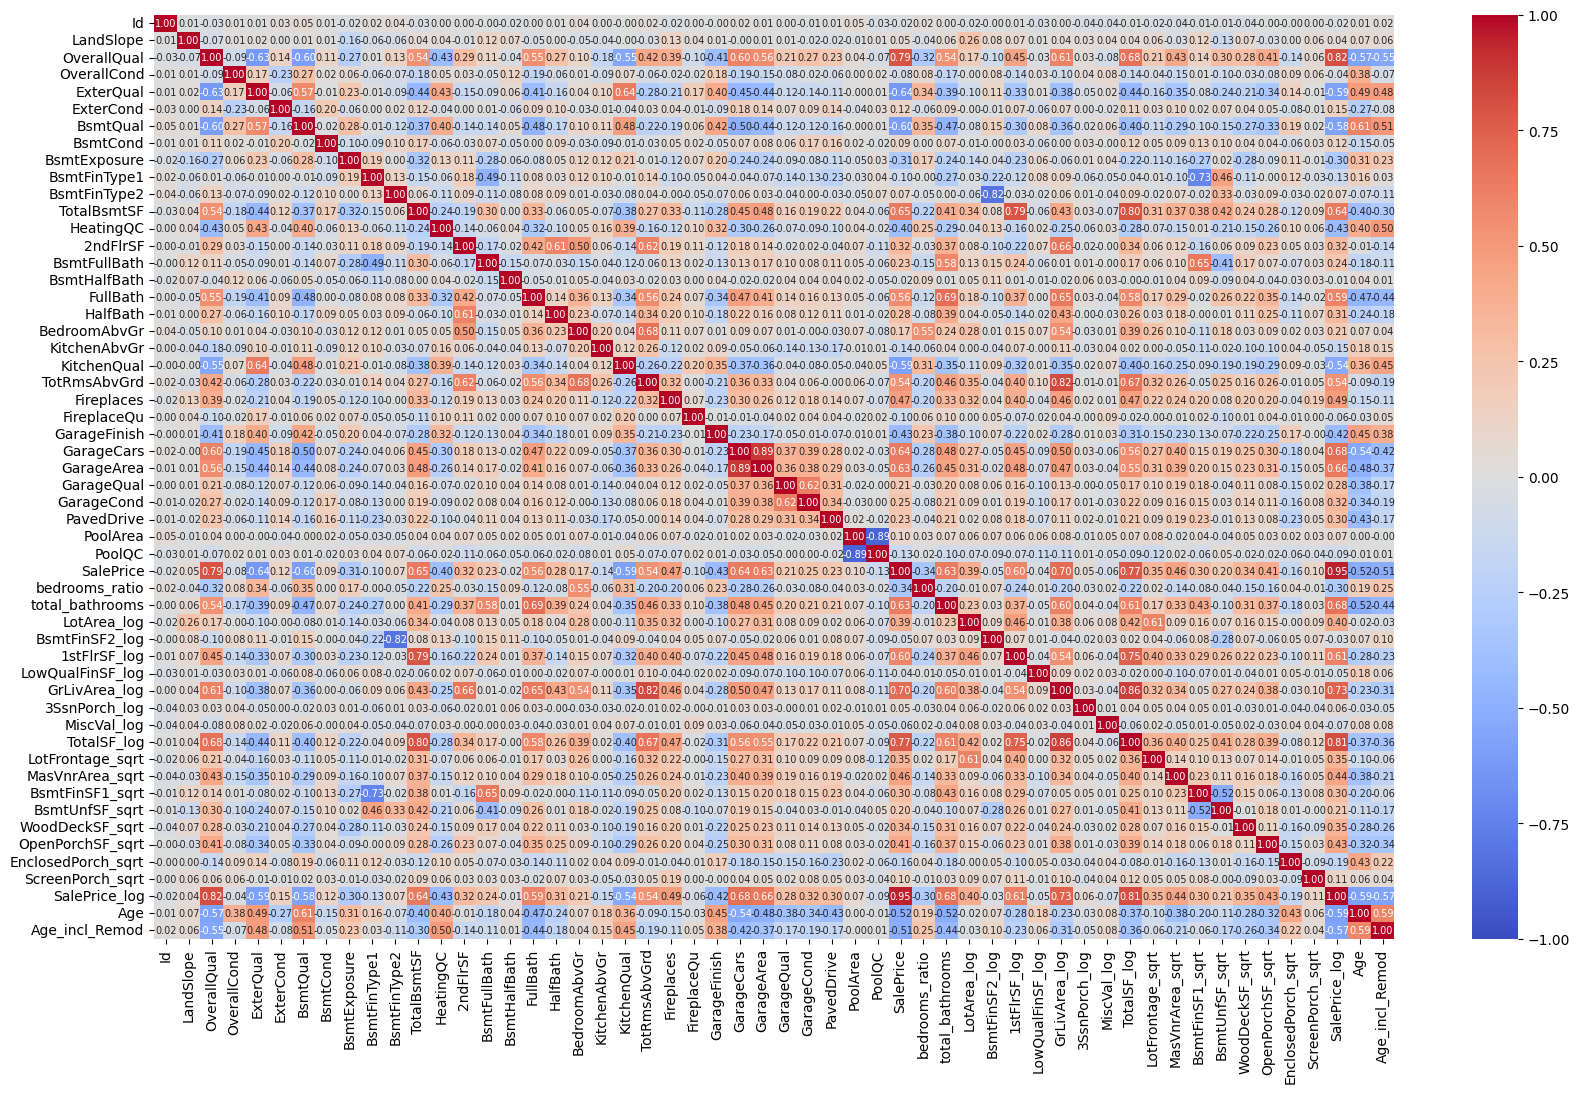

In [44]:
plt.figure(figsize=(20, 12))

sns.heatmap(data=train_eda_no_outliers.select_dtypes(np.number).corr(),
            vmin=-1,
            vmax=1,
            fmt = '.2f',
            annot=True,
            annot_kws = {'fontsize': 7},
            cmap = 'coolwarm');

In [45]:
train_eda_no_outliers.select_dtypes(np.number).corr()['SalePrice_log'].sort_values(ascending=False)

SalePrice_log         1.000000
SalePrice             0.948381
OverallQual           0.819626
TotalSF_log           0.814408
GrLivArea_log         0.734622
GarageCars            0.680672
total_bathrooms       0.675189
GarageArea            0.655609
TotalBsmtSF           0.642886
1stFlrSF_log          0.613435
FullBath              0.594956
TotRmsAbvGrd          0.536760
Fireplaces            0.492031
MasVnrArea_sqrt       0.441752
OpenPorchSF_sqrt      0.428751
LotArea_log           0.402043
WoodDeckSF_sqrt       0.354551
LotFrontage_sqrt      0.352101
GarageCond            0.323723
2ndFlrSF              0.319604
HalfBath              0.314232
PavedDrive            0.304718
BsmtFinSF1_sqrt       0.303531
GarageQual            0.275725
BsmtFullBath          0.237189
BsmtUnfSF_sqrt        0.214591
BedroomAbvGr          0.209058
ExterCond             0.148594
BsmtCond              0.122480
ScreenPorch_sqrt      0.113659
PoolArea              0.074325
BsmtFinType2          0.074021
3SsnPorc

# Preprocessing

Let's put together all the necessary lines of code (imputation, log/sqrt transformations, new features, etc.) that we created earlier.

In [46]:
train_df = train.copy()
test_df = test.copy()

# define variables to perform imputation
garage_object_cols = train_df.loc[:, train_df.columns.str.contains('Garage')].select_dtypes(object).columns
garage_num_cols = train_df.loc[:, train_df.columns.str.contains('Garage')].select_dtypes(np.number).columns
bsmt_object_cols = train_df.loc[:, train_df.columns.str.contains('Bsmt')].select_dtypes(object).columns
bsmt_num_cols = train_df.loc[:, train_df.columns.str.contains('Bsmt')].select_dtypes(np.number).columns
masvnr_cols = train_df.columns[train_df.columns.str.contains('MasVnr')].tolist()
impute_none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

# impute with none
train_df = impute_with_none(train_df)
test_df = impute_with_none(test_df)

# impute with mean (LotFrontage)
train_df = impute_with_mean_LF(train_df,train_df)
test_df = impute_with_mean_LF(test_df, train_df)

# define variables to impute missing values with the most frequent value
train_impute_mode_cols = train_df.columns[train_df.isna().any(axis=0)]
test_impute_mode_cols = test_df.columns[test_df.isna().any(axis=0)]

# impute with mode
train_df = impute_with_mode(train_df, train_df, train_impute_mode_cols)
test_df = impute_with_mode(test_df, train_df, test_impute_mode_cols)

# define variables by data types
## one-hot encoding
cat_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','Neighborhood',
                'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                'Heating','CentralAir','Electrical','Functional','GarageType','Fence','MiscFeature','SaleType','SaleCondition']

## ordinal encoding
ordinal_features = ['LandSlope','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                    'HeatingQC','KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive', 'PoolQC']

## no change required
ordinal_features_v2 = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars']

## no change/log/sqrt
continuous_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                       'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
## dates
dates_features = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']

# map MSSubClass
MSSubClass_mapping = {20: '1-STORY 1946',
                      30: '1-STORY 1945',
                      40: '1-STORY FIN',
                      45: '1-1/2 STORY UNF',
                      50: '1-1/2 STORY FIN',
                      60: '2-STORY 1946',
                      70: '2-STORY 1945',
                      75: '2-1/2 STORY',
                      80: 'SPLIT/MULTILEV',
                      85: 'SPLIT FOYER',
                      90: 'DUPLEX',
                      120: '1-STORY PUD',
                      150: '1-1/2 STORY PUD',
                      160: '2-STORY PUD',
                      180: 'PUD - MULTILEV',
                      190: '2 FAM CONV'
                     }

train_df['MSSubClass'] = train_df['MSSubClass'].map(MSSubClass_mapping)
test_df['MSSubClass'] = test_df['MSSubClass'].map(MSSubClass_mapping)

# convert object to category
train_df[cat_features] = train_df[cat_features].astype('category')

# simplify
train_df, test_df = simplify(train_df, test_df)

# perform OrdinalEncoding for variable 'ordinal_features' and convert to np.int16
ord_enc = OrdinalEncoder()

train_ord_transformed = ord_enc.fit_transform(train_df[ordinal_features])
test_ord_transformed = ord_enc.transform(test_df[ordinal_features])

train_df.loc[:, ordinal_features] = train_ord_transformed
train_df[ordinal_features] = train_df[ordinal_features].astype(np.int16)

test_df.loc[:, ordinal_features] = test_ord_transformed
test_df[ordinal_features] = test_df[ordinal_features].astype(np.int16)

# convert variable 'ordinal_features_v2' to np.int16
train_df[ordinal_features_v2] = train_df[ordinal_features_v2].astype(np.int16)
test_df[ordinal_features_v2] = test_df[ordinal_features_v2].astype(np.int16)

# add new discrete features
train_df = add_new_discrete_features(train_df)
test_df = add_new_discrete_features(test_df)

# add new continuous features
train_df = add_new_continous_features(train_df)
test_df = add_new_continous_features(test_df)

# difine variables for log and sqrt
log1p_features = ['LotArea','BsmtFinSF2','1stFlrSF','LowQualFinSF','GrLivArea','3SsnPorch','MiscVal','TotalSF']
sqrt_features = ['LotFrontage','MasVnrArea','BsmtFinSF1','BsmtUnfSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']

# perform log/sqrt transformation
train_df = transform_and_drop(train_df,log1p_features, sqrt_features)
test_df = transform_and_drop(test_df,log1p_features, sqrt_features)

# difine variable 'new_continuous_features'
original = ['TotalBsmtSF', '2ndFlrSF', 'GarageArea']
new_continuous_features = original + train_df.columns[train_df.columns.str.contains('log')].tolist() + train_df.columns[train_df.columns.str.contains('sqrt')].tolist()

# convert variable 'new_continuous_features' to np.float16
train_df[new_continuous_features] = train_df[new_continuous_features].astype(np.float16)
test_df[new_continuous_features] = test_df[new_continuous_features].astype(np.float16)

# add 'SalePrice_log' and drop 'SalePrice'
train_df['SalePrice_log'] = np.log(train_df['SalePrice'])
train_df = train_df.drop('SalePrice', axis=1)

# exclude one outlier using a variable 'significant_influential_points' 
train_df_no_outliers = train_df[significant_influential_points == 0]

# add age features
train_df_no_outliers = add_age_features(train_df_no_outliers).reset_index(drop=True)
test_df = add_age_features(test_df)

train_ord_transformed_yrmo = ord_enc.fit_transform(train_df_no_outliers[['YrMoSold']])
test_ord_transformed_yrmo = ord_enc.transform(test_df[['YrMoSold']])

train_df_no_outliers.loc[:, 'YrMoSold'] = train_ord_transformed_yrmo
train_df_no_outliers['YrMoSold'] = train_df_no_outliers['YrMoSold'].astype(np.int16)

test_df.loc[:, 'YrMoSold'] = test_ord_transformed_yrmo
test_df['YrMoSold'] = test_df['YrMoSold'].astype(np.int16)

# one-hot encoding
cat_features_v2 = train_df_no_outliers.select_dtypes('category').columns.tolist()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int8)

train_ohe = ohe.fit_transform(train_df_no_outliers[cat_features_v2])
test_ohe = ohe.transform(test_df[cat_features_v2])

feature_names = ohe.get_feature_names_out()

train_df_ohe = pd.DataFrame(train_ohe, columns = feature_names)
test_df_ohe = pd.DataFrame(test_ohe, columns = feature_names)

train_df_no_outliers = train_df_no_outliers.join(train_df_ohe).drop(cat_features_v2, axis=1)
test_df = test_df.join(test_df_ohe).drop(cat_features_v2, axis=1)

# standardization
std_cols = ['TotalBsmtSF','2ndFlrSF','GarageArea','PoolArea','Age','Age_incl_Remod','LotFrontage_sqrt', 'MasVnrArea_sqrt', 'BsmtFinSF1_sqrt','BsmtUnfSF_sqrt', 
            'WoodDeckSF_sqrt', 'OpenPorchSF_sqrt', 'EnclosedPorch_sqrt', 'ScreenPorch_sqrt']

std = StandardScaler()

train_std_transformed = std.fit_transform(train_df_no_outliers[std_cols])
test_std_transformed = std.transform(test_df[std_cols])

train_df_no_outliers.loc[:, std_cols] = train_std_transformed
test_df.loc[:, std_cols] = test_std_transformed

train_df_no_outliers[std_cols] = train_df_no_outliers[std_cols].astype(np.float16)
test_df[std_cols] = test_df[std_cols].astype(np.float16)

In [47]:
set(train_df_no_outliers) - set(test_df)

{'SalePrice_log'}

In [48]:
X_train = train_df_no_outliers.drop(['Id','SalePrice_log'], axis = 1)
y_train_log = train_df_no_outliers['SalePrice_log']

X_test = test_df.drop(['Id'], axis = 1)

# Modeling
## Linear Regression

In [49]:
lr = LinearRegression()

pred_log = cross_val_predict(lr, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 28045.49981157405


## Ridge

In [50]:
n_alphas  = 200
alphas = 10 ** np.linspace(-1, 3, n_alphas)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

ridge_cv.fit(X_train, y_train_log)

ridge_cv.alpha_

9.771241535346496

In [51]:
best_ridge_alpha = 9.771241535346496

ridge = Ridge(alpha = best_ridge_alpha)

pred_log = cross_val_predict(ridge, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 26350.650431487724


## Lasso

In [52]:
n_alphas  = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

lasso_cv = LassoCV(alphas = alphas, cv = 5, max_iter = 5000)

lasso_cv.fit(X_train, y_train_log)

lasso_cv.alpha_

0.001

In [53]:
best_lasso_alpha = 0.001

lasso = Lasso(alpha = best_lasso_alpha, max_iter = 5000)

pred_log = cross_val_predict(lasso, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 27935.02014403162


## Random Forest

In [54]:
rf = RandomForestRegressor(random_state = 42)

pred_log = cross_val_predict(rf, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 29501.75809189742


In [55]:
# rf = RandomForestRegressor(random_state = 42)

# params = {
#     'max_features': ['sqrt', 'log2', None],
#     'min_samples_split': np.arange(2, 16),
#     'max_leaf_nodes': np.arange(start = 100, stop = 1001, step = 100),
#     'min_samples_leaf': np.arange(start = 1, stop = 11, step = 1),
#     'n_estimators': np.arange(start = 100, stop = 1001, step = 100),
#     'max_samples': [.5,.7,.9,None]
# }

# rs = RandomizedSearchCV(
#     rf, params, n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1
# )

# rs.fit(X_train, y_train_log)

# rf_best_params =  rs.best_params_
# rf_best_params

In [56]:
# rf = RandomForestRegressor(random_state = 42)

# params = {
#      'n_estimators': [900],
#      'min_samples_split': [2],
#      'min_samples_leaf': [2],
#      'max_samples': [None],
#      'max_leaf_nodes': np.arange(230, 301, 10),
#      'max_features': [None]
# }

# gs = GridSearchCV(
#     rf, params, cv = 3, n_jobs = -1, verbose = 1
# )

# gs.fit(X_train, y_train_log)

# rf_best_params =  gs.best_params_
# rf_best_params

In [57]:
rf_best_params = {'max_features': None,
                  'max_leaf_nodes': 280,
                  'max_samples': None,
                  'min_samples_leaf': 2,
                  'min_samples_split': 2,
                  'n_estimators': 900}

In [58]:
rf = RandomForestRegressor(random_state = 42, **rf_best_params)

pred_log = cross_val_predict(rf, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 29606.298557543185


### Gradient Boost

In [59]:
gb = GradientBoostingRegressor(random_state = 42)

pred_log = cross_val_predict(gb, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 27127.68191353291


In [60]:
# gb = GradientBoostingRegressor(random_state = 42)

# params = {
#     'learning_rate': np.linspace(0.001, 0.1, 100),
#     'max_features': ['sqrt', 'log2', None],
#     'min_samples_split': np.arange(2, 16),
#     'max_leaf_nodes': np.arange(start = 100, stop = 1001, step = 100),
#     'min_samples_leaf': np.arange(2, 21),
#     'n_estimators': np.arange(start = 100, stop = 1001, step = 100),
#     'subsample': [0.7, .8, .9, .95]
# }

# rs = RandomizedSearchCV(
#     gb, params, n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1
# )

# rs.fit(X_train, y_train_log)

# gb_best_params =  rs.best_params_
# gb_best_params

In [61]:
# gb = GradientBoostingRegressor(random_state = 42)

# params = {'subsample': [0.9],
#           'n_estimators': [890],
#           'min_samples_split': [15],
#           'min_samples_leaf': [2],
#           'max_leaf_nodes': [3,4,5],
#           'max_features': ['sqrt'],
#           'learning_rate': [0.021]}


# gs = GridSearchCV(
#     gb, params, cv = 3, verbose = 1
# )

# gs.fit(X_train, y_train_log)

# gb_best_params =  gs.best_params_
# gb_best_params

In [62]:
gb_best_params = {'learning_rate': 0.021,
                  'max_features': 'sqrt',
                  'max_leaf_nodes': 5,
                  'min_samples_leaf': 2,
                  'min_samples_split': 15,
                  'n_estimators': 890,
                  'subsample': 0.9}

In [63]:
gb = GradientBoostingRegressor(random_state = 42, **gb_best_params)

pred_log = cross_val_predict(gb, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 26836.67324038365


### XGBoost

In [64]:
xgb = XGBRegressor(random_state = 42)

pred_log = cross_val_predict(xgb, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 29258.973956851347


In [65]:
# xgb = XGBRegressor(random_state = 42)

# params = {
#     'learning_rate': np.linspace(0.001, 0.1, 100),
#     'max_leaves': np.arange(start = 100, stop = 1001, step = 100),
#     'max_depth': np.arange(start = 3, stop = 11, step = 1),
#     'colsample_bytree': [.8, .9, .95],
#     'n_estimators': np.arange(start = 100, stop = 1001, step = 100),
#     'subsample': [.8, .9, .95],
#     'reg_lambda': [0.1, 1, 10]
# }

# rs = RandomizedSearchCV(
#     xgb, params, n_iter = 100, random_state = 42
# )

# rs.fit(X_train, y_train_log)

# xgb_best_params =  rs.best_params_
# xgb_best_params

In [66]:
# xgb = XGBRegressor(random_state = 42)

# params = {'subsample': [0.9],
#           'reg_lambda': [1],
#           'n_estimators': [830],
#           'max_leaves': np.arange(5, 11),
#           'max_depth': [3],
#           'learning_rate': [0.05],
#           'colsample_bytree': [0.9]}

# gs = GridSearchCV(
#     xgb, params, cv = 3, verbose = 1
# )

# gs.fit(X_train, y_train_log)

# xgb_best_params =  gs.best_params_
# xgb_best_params

In [67]:
xgb_best_params = {'colsample_bytree': 0.9,
                  'learning_rate': 0.05,
                  'max_depth': 3,
                  'max_leaves': 7,
                  'n_estimators': 830,
                  'reg_lambda': 1,
                  'subsample': 0.9}

In [68]:
xgb = XGBRegressor(random_state = 42, **xgb_best_params)

pred_log = cross_val_predict(xgb, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 26159.435279617417


### Voting

In [69]:
vt = VotingRegressor([
    ('ridge', Ridge(alpha = best_ridge_alpha)), 
#     ('rf', RandomForestRegressor(**rf_best_params)),
    # ('gb', GradientBoostingRegressor(**gb_best_params))
    ('xgb', XGBRegressor(**xgb_best_params))
], )

pred_log = cross_val_predict(vt, X_train, y_train_log, cv = 5)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 25251.553961554077


In [70]:
vt.fit(X_train, y_train_log)
pred_log = vt.predict(X_train)
pred = np.exp(pred_log)

rmse = mse(np.exp(y_train_log), pred, squared = False)

print(f'RMSE: {rmse}')

RMSE: 13739.60519245023


## Evaluate with Test Set

In [71]:
test_pred_log = vt.predict(X_test)
test_pred = np.exp(test_pred_log)
test_id = np.array(test['Id'])

test_df = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})
test_df

Id      SalePrice
0     1461  122902.039062
1     1462  155576.546875
2     1463  184135.703125
3     1464  194715.468750
4     1465  193626.625000
...    ...            ...
1454  2915   81394.664062
1455  2916   76184.656250
1456  2917  166404.312500
1457  2918  119489.960938
1458  2919  227703.625000

[1459 rows x 2 columns]

In [72]:
# test_df.to_csv('test_submission_vt_ridge_xgb.csv', index = False)

## Leaderboard score: 0.12176

# Summary

The best model was ``VotingRegressor``, with an RMSE score of 13,760 on the entire training set. The leaderboard score was 0.12176, placing it in the top 6% at the time of submission. It is intuitive to think that location-related features, such as latitude, longitude, and zipcode, would be good predictors of housing prices, but these were not included in this dataset. However, this dataset has ``neighborhood`` data, so it might be a good next step to explore if we can infer general location trends by researching the names in this feature, though this will require additional time. Additionally, while we have preprocessed the data using many custom functions, we could also utilize ``ColumnTrasformer``, ``Pipeline``, ``FunctionTransformer``, etc. to build a more sophisticated and streamlined preprocessing pipeline.

Thank you very much for reading this kernel!